# Pairwise mutation effects

### Pointwise mutations

We wish to investigate the effects of pairwise mutations at two different locations along the promoter.
To this end, we will consider how mutations at two points shift mean expression.
Let $S$ be the set of observed promoter sequences, and let $\chi:S\to \mathbb{R}$ be the map associating to each sequence its observed expression level.

For a sequence of interest $s\in S$, we denote its wildtype by $s^{*}$.
For any pair of equal length $n$ sequences $s$ and $s'$, we define the difference screen $\Delta(s, s')$ as the length $n$ binary string that is 0 at all positions for which $s$ and $s'$ agree, and 1 otherwise.
When comparing a sequence with its wildtype, we can refer to this screen as a mutation profile, and shorten notation according to $\Delta(s) = \Delta(s, s^*)$.
For any substring $\sigma$ of $s$, we will define $\Delta(\sigma)$ as the corresponding subtring of the string $\Delta(s,s^*)$.

Given a sequence $s\in S$, we can define a $k$-segmentation of the sequence according to a function 
$\sigma_i$ that maps a sequence to its $i$-th segment, a length $k$ substring at position $i$.
We can then define for each length $k$ binary string $b$ an indicator function $\mathbb{I}_{b}$, that is equal to 1 if and only if $\Delta(\sigma_i(s)) = b$, and 0 otherwise.
Where convenient, we will denote by $\mathbb{I}_{0}$ the indicator function asserting no mutations, regardless of the length $k$.

We define at each position (i.e. segment) along a promoter the mean wildtype expression $\mu_i^*$ that is the average expression level of all sequences whose $i$-th segments are not mutated. That is,
$$\mu_i^* = \frac{1}{N} \sum_{s\in S} \mathbb{I}_{0}[\sigma_{i}(s)] \chi(s)$$
where
$$N = \sum_{s\in S} \mathbb{I}_{0}[\sigma_{i}(s)].$$

Similarly, for a given mutation profile $b$, we can define at each position the mean expression $\mu_i^{(b)}$ of all sequences with mutation profile $b$ at position $i$:
$$
\begin{align*}
    \mu_i^{(b)} &= \frac{1}{N} \sum_{s\in S} \mathbb{I}_{b}[\sigma_{i}(s)] \chi(s) \\
    N &= \sum_{s\in S} \mathbb{I}_{b}[\sigma_{i}(s)].
\end{align*}
$$


### Pairwise mutations

For the case of pairwise mutations, we can similarly define the mean expression $\mu_{i,j}^{(b_1, b_2)}$ as the average expression level across all sequences with mutation profile $b_1$ at position $i$ and mutation profile $b_2$ at position $j$.
$$
\begin{align*}
    \mu_{i,j}^{(b_1, b_2)} &= \frac{1}{N} \sum_{s\in S} \mathbb{I}_{b_1}[\sigma_{i}(s)] \mathbb{I}_{b_2}[\sigma_{j}(s)] \chi(s) \\
    N &= \sum_{s\in S} \mathbb{I}_{b_1}[\sigma_{i}(s)] \mathbb{I}_{b_2}[\sigma_{j}(s)].
\end{align*}
$$


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from promdis.processing import get_sequence_arrays_and_counts, gene_seq_to_array
from promdis.core import compute_pairwise_segmented_mean_expression
from promdis.helpers import binary_arr_to_int, int_to_binary_arr

In [2]:
FPATH = "../data/expression_data/ykgE_dataset_combined.csv"


In [3]:
df = pd.read_csv(FPATH)
df['barcode'] = df['seq'].str.slice(160,)
df['promoter'] = df['seq'].str.slice(0, 160)
df

,ct,ct_0,ct_1,seq,barcode,promoter
0,1.0,1.0,0.0,ACAATTTCACCATAAAATGTCGGCGTTGCCGAAAGAAATAAAATGA...,GAGAGCCTCGCGTATCCCTC,ACAATTTCACCATAAAATGTCGGCGTTGCCGAAAGAAATAAAATGA...
1,1.0,1.0,0.0,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTA...,GGATCCATGGTCATTCGGTG,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTA...
2,1.0,1.0,0.0,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTA...,TATTACGGTACGAGATTGCT,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTA...
3,2.0,2.0,0.0,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGA...,AACTCTCACTCTGCTGTACG,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGA...
4,2.0,2.0,0.0,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGA...,TACCCGTGTTCGTAACCCCT,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGA...
...,...,...,...,...,...,...
2585,1.0,1.0,0.0,TTGTTTTCGCCATAAATTGTGAGCGATGCCGTAAGAAACAAAATTA...,CGCATACGGTAGAAGCGGAA,TTGTTTTCGCCATAAATTGTGAGCGATGCCGTAAGAAACAAAATTA...
2586,2.0,1.0,1.0,TTGTTTTTCCCAGAAAATGTAAGTCACGTCGACAGAAATAAAATTA...,CGTCCTTTACGTACTATGGG,TTGTTTTTCCCAGAAAATGTAAGTCACGTCGACAGAAATAAAATTA...
2587,1.0,1.0,0.0,TTGTTTTTCCCAGAAAATGTAAGTCACGTCGACAGAAATAAAATTA...,CACGTCAGCGGCCCTCTTAC,TTGTTTTTCCCAGAAAATGTAAGTCACGTCGACAGAAATAAAATTA...
2588,1.0,1.0,0.0,TTGTTTTTCCCAGAAAATGTAAGTCACGTCGACAGAAATAAAATTA...,GTATCCGTGCGACCATCCAA,TTGTTTTTCCCAGAAAATGTAAGTCACGTCGACAGAAATAAAATTA...


In [4]:
seqs, counts_dna, counts_rna = get_sequence_arrays_and_counts(
    df, key_promoter='promoter', key_rna='ct_1', key_dna='ct_0'
)

expression = counts_rna / (counts_dna + counts_rna)

In [5]:
# Load wildtype data

GENE = 'ykgE'

WT_GENES_FPATH = "../data/wtsequences.csv"

wildtype_genes_df = pd.read_csv(WT_GENES_FPATH)

WT_GENE_SEQUENCES = {
    g: wildtype_genes_df.loc[wildtype_genes_df['name'] == g,'geneseq'].values[0]
    for g in wildtype_genes_df['name'].unique()
}

GENE_WT_SEQ = WT_GENE_SEQUENCES[GENE]

nbases = len(GENE_WT_SEQ)
print(f"{GENE} wildtype sequence (length {nbases}):\n", GENE_WT_SEQ)

wt_seq = gene_seq_to_array(GENE_WT_SEQ)

ykgE wildtype sequence (length 160):
 TCGATTTCCCCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTAGTTATTGCATTTGACGTTTGGATGAAAGATTATCATTTGTCATACAAATGAGGGGTGGTATGTTGCTAGCCAATTAAAAAAGAACGCCATATTTATTGATGATTGATCCCCCGG


Using segments of length $k$, there are $2^k$ possible pairs of mutation profiles, and we can map each integer in the set $\{0,\ldots,k-1\}$ to its binary representation $(\cdot)_2$.
The function below computes for every pair of mutation profiles $b_1$ and $b_2$ the mean expression across all segments with mutation profile $b_1$ at position $i$ and mutation profile $b_2$ at position $j$.
That is, `mu[idx1,idx2]` below yields an $80 \times 80$ matrix whose $(i, j)$ entry is the average expression of sequences with mutation profiles $(\texttt{idx1})_2$ and $(\texttt{idx2})_2$ at positions $i$ and $j$, respectively. 

In [6]:
mu = compute_pairwise_segmented_mean_expression(
    seqs, expression, wt_seq, 2
)

/Users/addisonhowe/Documents/Projects/promoter-dissection/promdis/core.py:228: RuntimeWarning: invalid value encountered in divide
  mean_exp_by_index[mutidx1, mutidx2,:,:] = np.sum(


With the computed mean expression values obtained, we can plot the average wildtype expression.

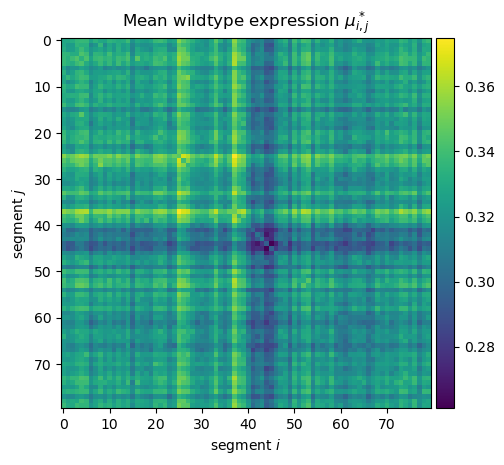

In [7]:
fig, ax = plt.subplots(1, 1)

sc = ax.imshow(mu[0,0])
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig = ax.figure
cbar = fig.colorbar(sc, cax=cax)

ax.set_title("Mean wildtype expression $\\mu_{i, j}^*$")
ax.set_xlabel(f"segment $i$")
ax.set_ylabel(f"segment $j$");


We can then compute the expression shift $\xi$, which we define as the difference between the mean expression of sequences with mutation profiles $b_1$, $b_2$ at positions $i$, $j$, respectively, and the mean wildtype expression.

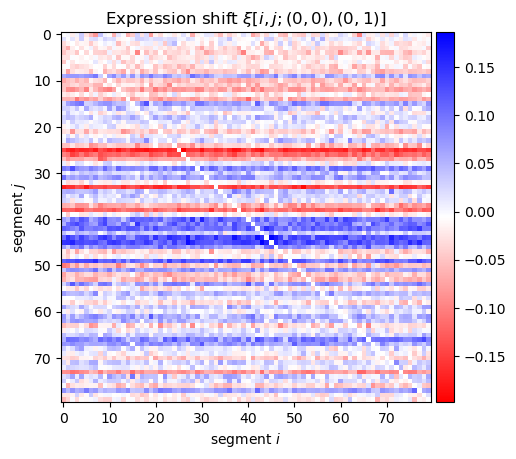

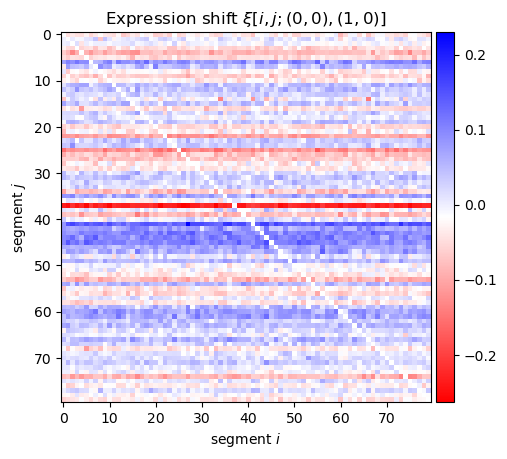

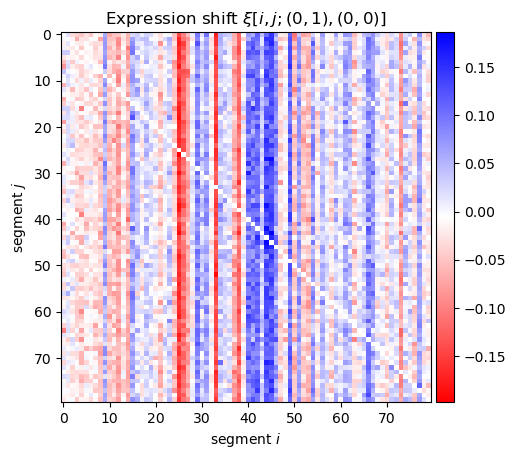

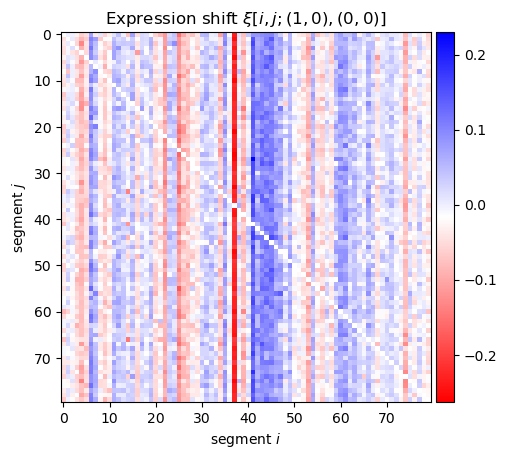

In [8]:
mutation_profiles = [
    [(0, 0), (0, 1)],
    [(0, 0), (1, 0)],
    [(0, 1), (0, 0)],
    [(1, 0), (0, 0)],
]

for b1, b2 in mutation_profiles:
    idx1 = binary_arr_to_int(np.array(b1))
    idx2 = binary_arr_to_int(np.array(b2))
    xi = mu[idx1, idx2] - mu[0, 0]

    fig, ax = plt.subplots(1, 1)
    sc = ax.imshow(xi.T, cmap='bwr_r')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig = ax.figure
    cbar = fig.colorbar(sc, cax=cax)
    ax.set_xlabel(f"segment $i$")
    ax.set_ylabel(f"segment $j$")
    ax.set_title(f"Expression shift $\\xi[i,j;{b1},{b2}]$")
    

Finally, we can aggregate the mean expression levels that occur when a single base pair mutation is made, or when exactly two mutations are made.

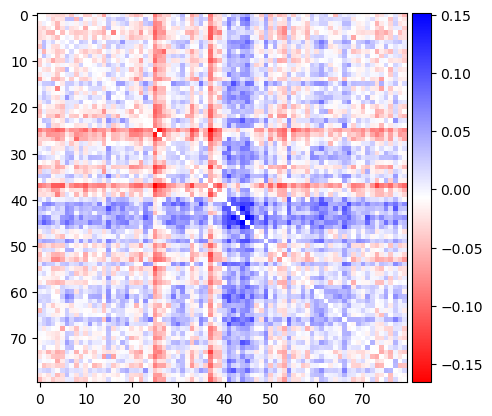

In [9]:
# All instances with a single base pair mutation across the 4 sites of interest.
gamma1 = (mu[0,1] + mu[1,0] + mu[2, 0] + mu[0,2]) / 4 - mu[0,0]

fig, ax = plt.subplots(1, 1)

sc = ax.imshow(gamma1.T, cmap='bwr_r')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig = ax.figure
cbar = fig.colorbar(sc, cax=cax)


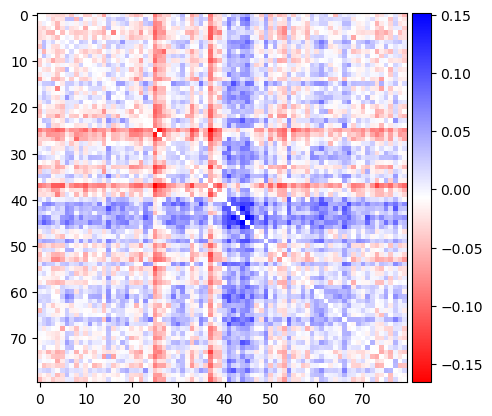

In [10]:
# All instances with two base pair mutations across the 4 sites of interest.
gamma2 = (mu[0,3] + mu[3,0] + mu[1, 1] + mu[1,2] + mu[2, 1] + mu[2,2]) / 6 - mu[0,0]

fig, ax = plt.subplots(1, 1)

sc = ax.imshow(gamma1.T, cmap='bwr_r')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig = ax.figure
cbar = fig.colorbar(sc, cax=cax)
